# Introduction

This notebook is to train DenseNEt model and evaluate the results of this model.

---

## Concepts used

#### 1. Convolution Layers

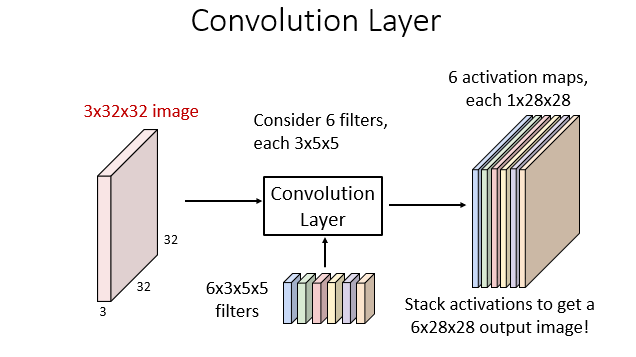

#### 2. MaxPool Layer

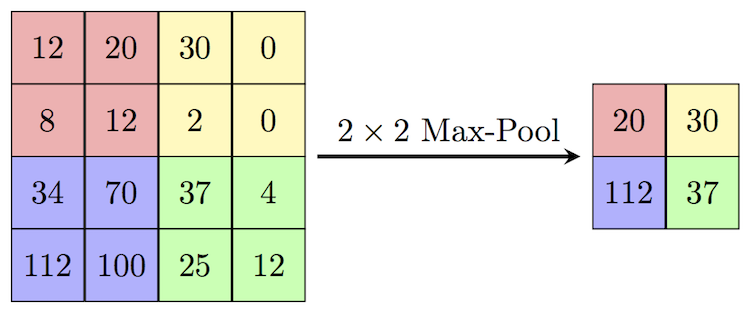

#### 3. Relu Activation

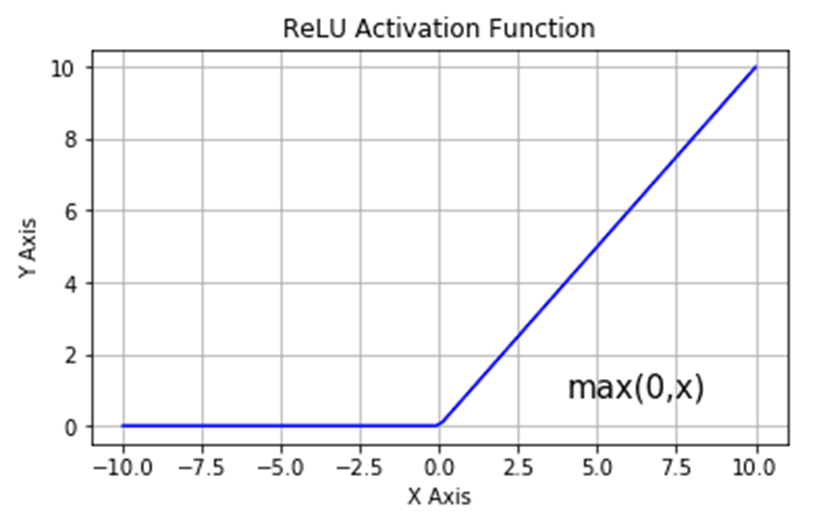

#### 4. Sigmoid Activation 

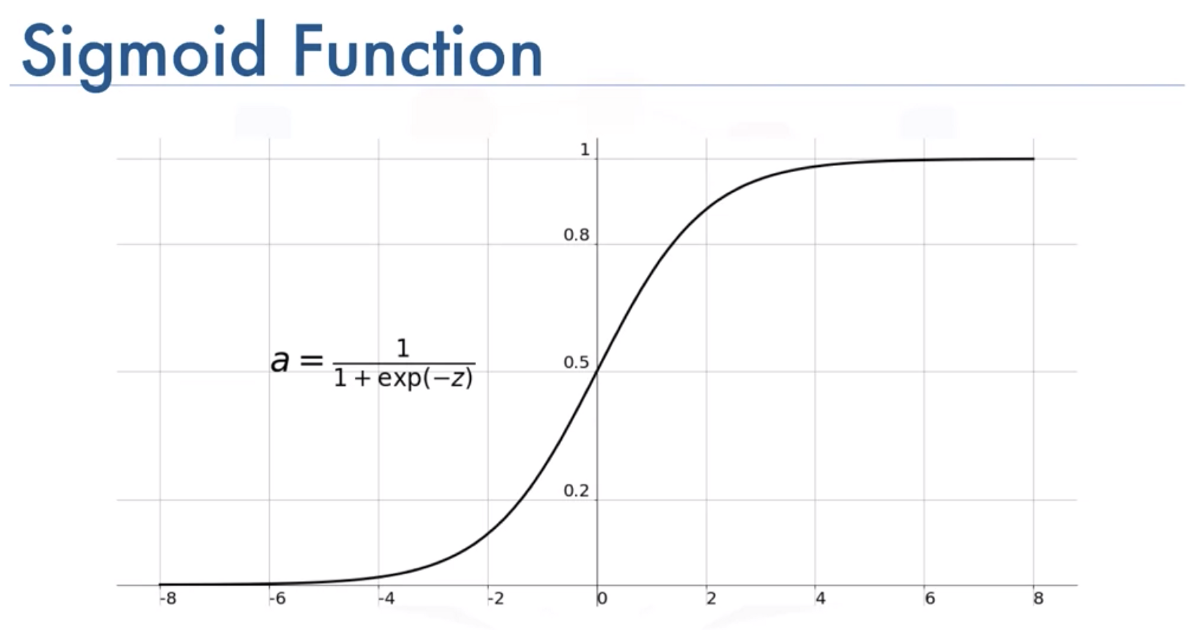

#### 5. Binary Cross Entropy 

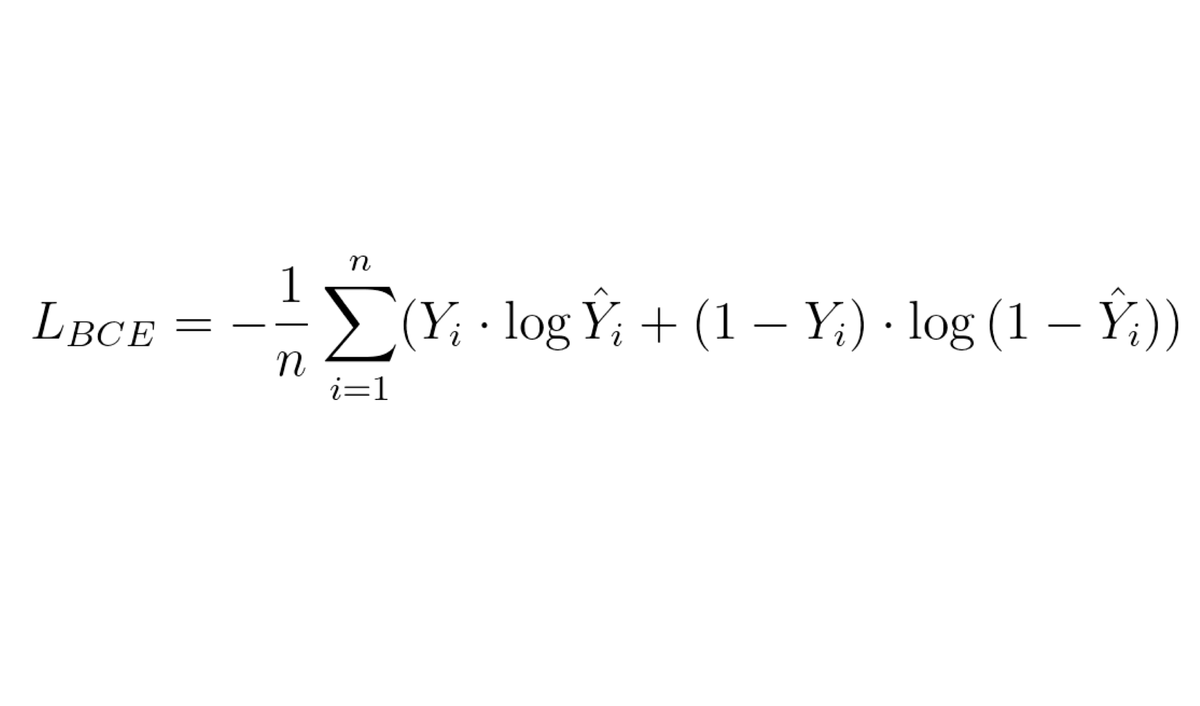

## Import Libraries

In [17]:
# ! pip install pandas
# ! pip install PIL
# ! pip install matplotlib
# ! pip install opencv_python
# ! pip install tqdm
# ! pip install scikit-learn

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2 
import os 
from os.path import join
from random import shuffle 
from tqdm import tqdm 
from PIL import Image

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import DenseNet121


import matplotlib.pyplot as plt

import warnings
import random
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  2
2.9.2


In [8]:
# ! ls ../data/raw/real_vs_fake/real_vs_fake/real-vs-fake/

In [9]:
train_pth = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
train_real = os.path.join(train_pth,'real/')
train_fake = os.path.join(train_pth,'fake/')

val_pth = r'/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/'
val_real = os.path.join(val_pth,'real/')
val_fake = os.path.join(val_pth,'fake/')

test_pth = r'/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/'

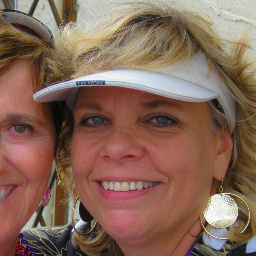

In [10]:
Image.open(join(train_real,random.choice(os.listdir(train_real))))


## Read images

Required directory scructure for keras's ImageGenerator. Our dataset follows this format so we have no need for such transformation.

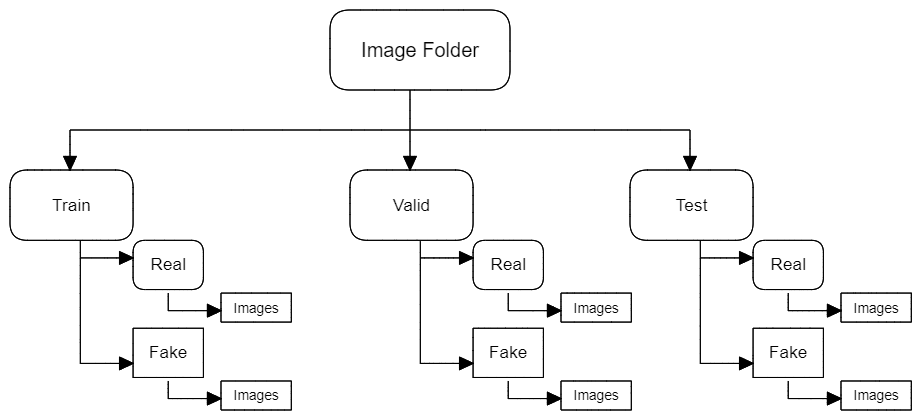

In [11]:
train = ImageDataGenerator()
val = ImageDataGenerator()
test = ImageDataGenerator()

train_dataset = train.flow_from_directory(train_pth,
                                          target_size=(224,224),
                                          batch_size = 32,
#                                           shuffle = False,
                                          class_mode = 'binary')
                                         
val_dataset = val.flow_from_directory(val_pth,
                                          target_size=(224,224),
                                          batch_size = 32,
                                          class_mode = 'binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [12]:
train_dataset.class_indices

{'fake': 0, 'real': 1}

In [13]:
# train_dataset.classes.tolist()[::-1]
train_dataset.labels


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

## DensNet - 121
---

The architecture of the DenseNEt - 121 designed for this looks like the following:



Visualizing this as input and out put cuboidal volumes it looks like:



In [14]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
#         layers.Dense(1000, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [18]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,1)
)
# densenet.summary()
model = build_model(densenet)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7031232   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
train_steps = 100000//32
valid_steps = 20000//32
model.fit_generator(train_dataset,
         steps_per_epoch = train_steps,
         epochs = 10,
         validation_data = val_dataset,
         validation_steps  = valid_steps
)

Epoch 1/10
3125/3125 [==============================] - 1255s 393ms/step - loss: 0.5619 - accuracy: 0.7029 - val_loss: 0.5392 - val_accuracy: 0.7411
Epoch 2/10
3125/3125 [==============================] - 1151s 368ms/step - loss: 0.3205 - accuracy: 0.8611 - val_loss: 0.2978 - val_accuracy: 0.8768
Epoch 3/10
3125/3125 [==============================] - 1145s 366ms/step - loss: 0.1855 - accuracy: 0.9263 - val_loss: 0.5281 - val_accuracy: 0.7806
Epoch 4/10
3125/3125 [==============================] - 1144s 366ms/step - loss: 0.1192 - accuracy: 0.9543 - val_loss: 0.4724 - val_accuracy: 0.8090
Epoch 5/10
3125/3125 [==============================] - 1144s 366ms/step - loss: 0.0802 - accuracy: 0.9699 - val_loss: 1.1176 - val_accuracy: 0.6797
Epoch 6/10
3125/3125 [==============================] - 1144s 366ms/step - loss: 0.0578 - accuracy: 0.9783 - val_loss: 0.3267 - val_accuracy: 0.8791
Epoch 7/10
3125/3125 [==============================] - 1145s 366ms/step - loss: 0.0445 - accuracy: 0.9835

In [20]:
model.save('densenet-121.h5')

### Validation result

In [26]:
val_dataset = val.flow_from_directory(val_pth,
                                          target_size=(224,224),
                                          batch_size =32,
                                          shuffle = False,
                                        color_mode='grayscale',
                                          class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [27]:
THRESH = 0.5
val_predict = model.predict(val_dataset).reshape(-1)
val_predict = np.where(val_predict > THRESH,1,0)
val_predict.shape

625/625 [==============================] - 65s 104ms/step


(20000,)

In [28]:
val_predict

array([0, 0, 0, ..., 1, 1, 1])

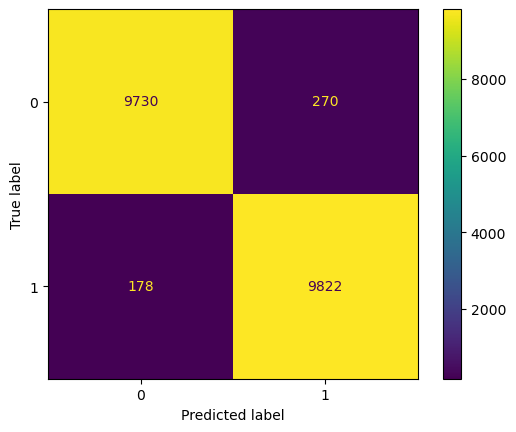

In [29]:
cm = confusion_matrix(val_dataset.classes, val_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

plt.show()

In [31]:
f1_score(val_dataset.classes, val_predict)

0.9777025681863428

In [32]:
score = model.evaluate(val_dataset,batch_size = 32)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

625/625 [==============================] - 66s 105ms/step - loss: 0.0632 - accuracy: 0.9776
Validation loss: 0.06320376694202423
Validation accuracy: 0.9775999784469604


In [33]:
print('Validation Acc: ', 100*np.sum(val_predict == val_dataset.classes)/len(val_dataset.classes))


Validation Acc:  97.76


### Test result

In [34]:
test_dataset = test.flow_from_directory(test_pth,
                                          target_size=(224,224),
                                          batch_size =32,
                                          shuffle = False,
                                          color_mode='grayscale',
                                          class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [35]:
THRESH=0.5
test_predict = model.predict_generator(test_dataset)
test_predict = np.where(test_predict > THRESH,1,0)

test_predict

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

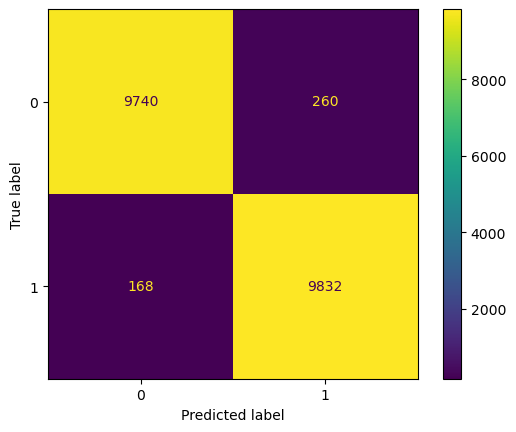

In [36]:
cm = confusion_matrix(test_dataset.classes, test_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [37]:
f1_score(test_dataset.classes, test_predict)

0.9786979892494525

In [38]:
score = model.evaluate_generator(test_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06041893735527992
Test accuracy: 0.978600025177002
